<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/temperature_forecasting_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 01st Feb, 2023
# My folder: /home/ashok/Documents/14.sensor_data
# VM: lubuntu_deeplearning_I.vdi
# Ref: Page 207, Chapter 6, Deep Learning with Python by Fracois Chollete
# Download dataset from:
# 1. Link to my google drive
#  https://drive.google.com/file/d/1rnhlFKmmmhXqawaIBgjSTsqGrTLCUldV/view?usp=sharing
# 2. Link to original datasource
#  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [ ]:
# Objectives:
#             i)  Working with timeseries data
#             i)  Working with sensor data
#                 (Data comes from many sensors)
#             ii) Processing data to make it fit for modeling
#            iii) Creating a data generator for training and validation
#            iv)  Making predictions using
#                   a) Fully connected dense model
#                   b) GRU model
#                   c) GRU model with dropouts
#                   d) Stacked GRU models
#                   e) Bidirectional RNN layer
#
#

## Task

In [ ]:
# We will predict temperature
# Sensor data is recorded every 10 minutes. So per-day we have:
#   no of minutes:              24 * 60     =  1440
#   no of 10 minutes interval: (24 * 60)/10 = 144 datapoints/per day
#   no of data-points in 10 days: 1440

## Call libraries

In [1]:
# 1.0 Reset all variables
#%reset -f

# 1.0 Call libraries
import numpy as np
import matplotlib.pyplot as plt
import os, time, gc, pathlib

In [2]:
# 1.0.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Mount gdrive

In [3]:
# 1.1
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## How to read csv data in numpy

In [5]:
# 1.1 Where is my data foler?
data_dir = '/gdrive/MyDrive/Colab_data_files/jena'

# 1.1.0 Make data_dir a pathlib object
folderPath = pathlib.Path(data_dir)

In [50]:
# 1.2 Join datapath with filename (intelligently)
#     If you are on Windows, assign to fname full
#     data path+ filename
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
fname

'/gdrive/MyDrive/Colab_data_files/jena/jena_climate_2009_2016.csv'

In [6]:
# 1.2 Get filename
fname = folderPath / 'jena_climate_2009_2016.csv'

In [7]:
# 1.3 Read datafile, line by line
# 1.3.1 First get a handle to file
f = open(fname)   # open() default mode is text+read
# 1.3.2 Use handle to read complete file
data = f.read()

In [8]:
# 1.3.3 Close read file
f.close()

In [9]:
type(data)

str

## Observe read file data
Basic python operations on file

In [10]:
# 1.3.4 Check data type
assert type(data) is str
print("\n====\n")
type(data) #  str


====



str

In [35]:
# 1.3.5 Observe data string

data[0:200]      # Whole data is read as one string
                 # Read first 200 characters of string
                 # Note '\n' at 196th character


'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.0'

In [11]:
# 1.4 Look at data
# 1.4.1 Split data on newline (\n). So how many records?
lines = data.split('\n')    # Split data 'str' at every 'newline'
                            # and collect the str(s) in a list
print("\n=====\n")
type(lines)                 # list =>  All splits are in one list
print("\n=====\n")
len(lines)                  # Total splits/elements are 420552
print("\n=====\n")
lines[3]                    # Just print some element of list




=====



list


=====



420552


=====



'01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60'

In [13]:
# 1.4.2 Does any header exist? Check
lines[0]                   # yes, it does
print("\n=====\n")
lines[1]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"'


=====



'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [ ]:
# 1.4.3.1 Actual data from csv file
#         Note each col-header is a string
#         but each col value is NOT
"""
"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
"""

In [15]:
# 1.4.3 Extract header (field-names)
header = lines[0].split(',')  # Split at each ','
header  # A list of strs AND within each string is a string

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [16]:
# 1.4.4 How many columns/fields?
cols = len(header)
cols             # 15

15

In [18]:
# 1.4.5 Print first three rows.
#       Note 10-minute gap in the
#       observations
lines[1:4]     # A list of 3 string elements
print("\n======\n")
len(lines)    # 420552 or header + 420551 data points

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

420552

In [19]:
# 1.4.6 Total samples?
totalsamples = len(lines) - 1    # 420551 (exclude header)
totalsamples

420551

## Data conversion to numpy
Transform our `lines` to numpy array

In [21]:
# 2.0 Convert all 420551 data points into a numpy array
#     for processing

# 2.1 First create a zero-valued 2D-array
#      While creating zero-valued 2D-array, forget
#        first column or time col
#     So array size will be same as that of data

float_data = np.zeros((totalsamples, cols -1 ))  # Exclude 1st date/time col
float_data.shape           # (420551,14)

(420551, 14)

In [22]:
# 2.2 Fill this 2D-zero-valued array, row-by-row using for-loop
# 2.2.1 First get an array of 420551 values
#       0 ,1, 2, 3,...420550

numbList=np.arange(len(lines) - 1 )
numbList

array([     0,      1,      2, ..., 420548, 420549, 420550])

In [23]:
# 2.2.2 See how a line is split in respective
#       field values. We want split values to
#       be an array. But after the split,
#       they are a list

x = lines[1].split(',')
type(x)      # list

list

In [25]:
# 2.2.3 Transform just one element of 'lines' into numpy array
x = np.asarray(x[1:], dtype = 'float32') # Exclude 1st date/time column
type(x)
print("\n======\n")
x

numpy.ndarray

array([-8.02000e+00,  2.65400e+02, -8.90000e+00,  9.33000e+01,
        3.33000e+00,  3.11000e+00,  2.20000e-01,  1.94000e+00,
        3.12000e+00,  1.30775e+03,  1.03000e+00,  1.75000e+00,
        1.52300e+02], dtype=float32)

In [26]:
# 2.3  Fill up zero-array,row-by-row, with sensor data
for i in numbList:      # ie uptil the last line
    # 2.3 Now do this for all lines using for-loop
    row = lines[i+1].split(',')     # i starts from 0 but we ignore header
    # 2.3.1 'row' is a list. Select all but 1st element
    row= row[1:]                    # Ignore the date column
    values = np.asarray(row, dtype = 'float32')
    float_data[i, :] = values      # Fill zero-array, row-by-row

In [28]:
# 2.3.2 Check
float_data.shape     # (420551,14)
print("\n======\n")
# 2.3.2
float_data[0]

(420551, 14)

array([ 9.96520020e+02, -8.02000046e+00,  2.65399994e+02, -8.89999962e+00,
        9.33000031e+01,  3.32999992e+00,  3.10999990e+00,  2.19999999e-01,
        1.94000006e+00,  3.11999989e+00,  1.30775000e+03,  1.02999997e+00,
        1.75000000e+00,  1.52300003e+02])

## Plotting temperature

In [29]:
# 3. Let us plot temperature, the IInd column
#    Check 'header', if you like
# 3.1 Get IInd column with index 1
temp = float_data[:, 1]
temp

array([-8.02000046, -8.40999985, -8.51000023, ..., -3.16000009,
       -4.23000002, -4.82000017])

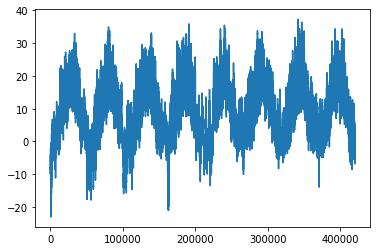

In [31]:
# 3.2 plot it. It is highly periodic
plt.plot(range(len(temp)), temp) ;
plt.show() ; 